<a href="https://www.kaggle.com/code/carlosalvro/bank-churn-analisys?scriptVersionId=161097662" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
sns.set_palette("tab10")

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:
# competetion dataset 
test_path = "/kaggle/input/playground-series-s4e1/test.csv"
train_path = "/kaggle/input/playground-series-s4e1/train.csv"
test = pd.read_csv(test_path)
train = pd.read_csv(train_path)

## General overview of the features
Let's see what it mean each feature

0. **ID**: Identifier
1. **Customer ID**: A unique identifier for each customer
2. **Surname**: The customer's surname or last name
3. **Credit Score**: A numerical value representing the customer's credit score
4. **Geography**: The country where the customer resides (France, Spain or Germany)
5. **Gender**: The customer's gender (Male or Female)
6. **Age**: The customer's age.
7. **Tenure**: The number of years the customer has been with the bank
8. **Balance**: The customer's account balance
9. **NumOfProducts**: The number of bank products the customer uses (e.g., savings account, credit card)
10. **HasCrCard**: Whether the customer has a credit card (1 = yes, 0 = no)
11. **IsActiveMember**: Whether the customer is an active member (1 = yes, 0 = no)
12. **EstimatedSalary**: The estimated salary of the customer
13. **Exited**: Whether the customer has churned (1 = yes, 0 = no)

At first glance we can see that the id's columns will not be useful for our analisys.
So let's start analysing each feature, except those two.

### Surname
The customer's surname or last name, maybe we can find some relation between the name and if this name exited.


In [3]:
surnames = train['Surname'].value_counts()
print(surnames)

Surname
Hsia         2456
T'ien        2282
Hs?          1611
Kao          1577
Maclean      1577
             ... 
Samaniego       1
Lawley          1
Bonwick         1
Tennant         1
Elkins          1
Name: count, Length: 2797, dtype: int64


Now we see that there are reapeated Surnames, but in general we have 2,797 unique values of surnames.

### Credit Score
A numerical value representing the customer's credit score

In [4]:
train['CreditScore'].describe()

count    165034.000000
mean        656.454373
std          80.103340
min         350.000000
25%         597.000000
50%         659.000000
75%         710.000000
max         850.000000
Name: CreditScore, dtype: float64

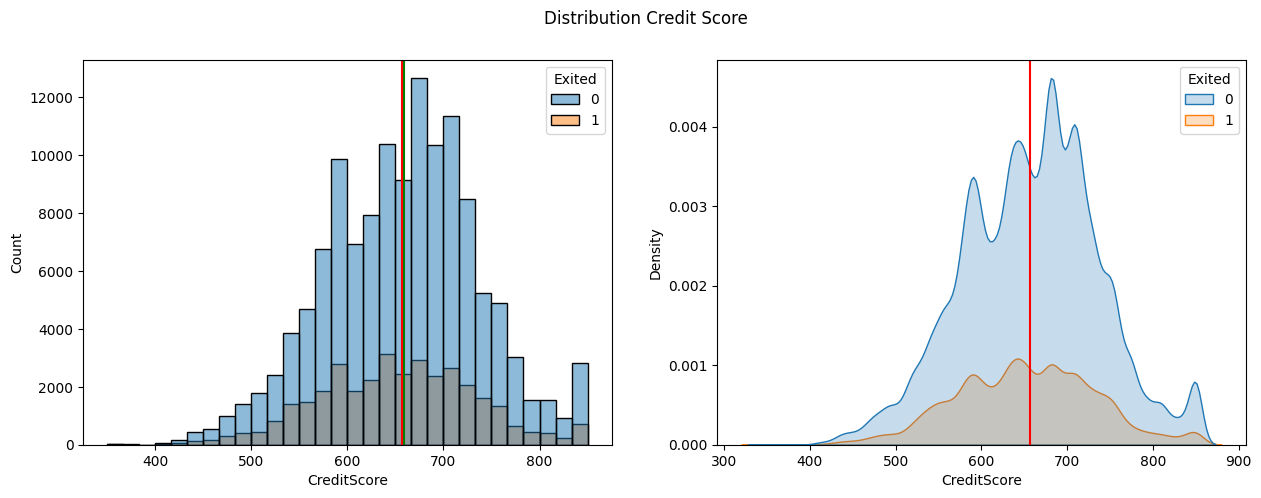

In [5]:
mean = train['CreditScore'].mean()
median = train['CreditScore'].median()

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train, x = 'CreditScore', bins=30, hue='Exited', ax=ax[0])
ax[0].axvline(median, c='g')
ax[0].axvline(mean,c = 'r')

sns.kdeplot(data=train, x = 'CreditScore', hue='Exited', fill=True, ax=ax[1])
ax[1].axvline(mean,c = 'r', label='mean')
fig.suptitle('Distribution Credit Score')
plt.show()

We can see that we have values of credit Score between 350 and 850,with a mean value of 656. The distributón looks very similar between the exited and not exited values 

### Geography
The country where the customer resides (France, Spain or Germany)

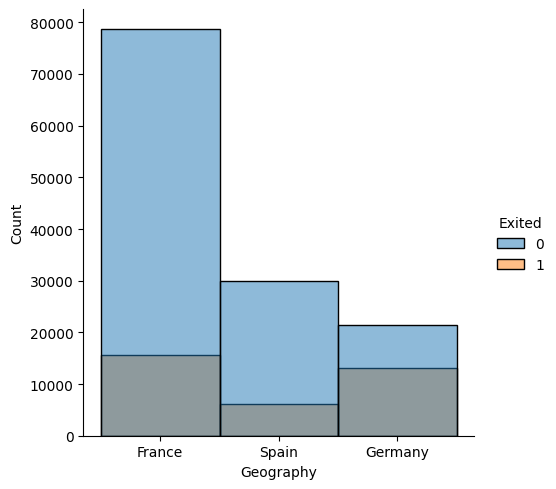

In [6]:
sns.displot(data=train, x = 'Geography', hue='Exited')

### Gender
The customer's gender (Male or Female)

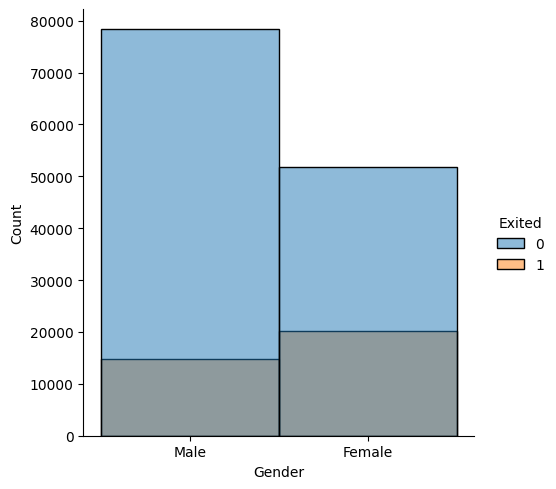

In [7]:
sns.displot(data=train, x = 'Gender', hue='Exited')

In [8]:
train['Gender'] = train['Gender'].map({'Male':0, 'Female':1})
test['Gender'] = test['Gender'].map({'Male':0, 'Female':1})

### Age 
The customer's age.

In [9]:
train['Age'].describe()
train['Age'] = train['Age'].astype(int)
test['Age'] = test['Age'].astype(int)

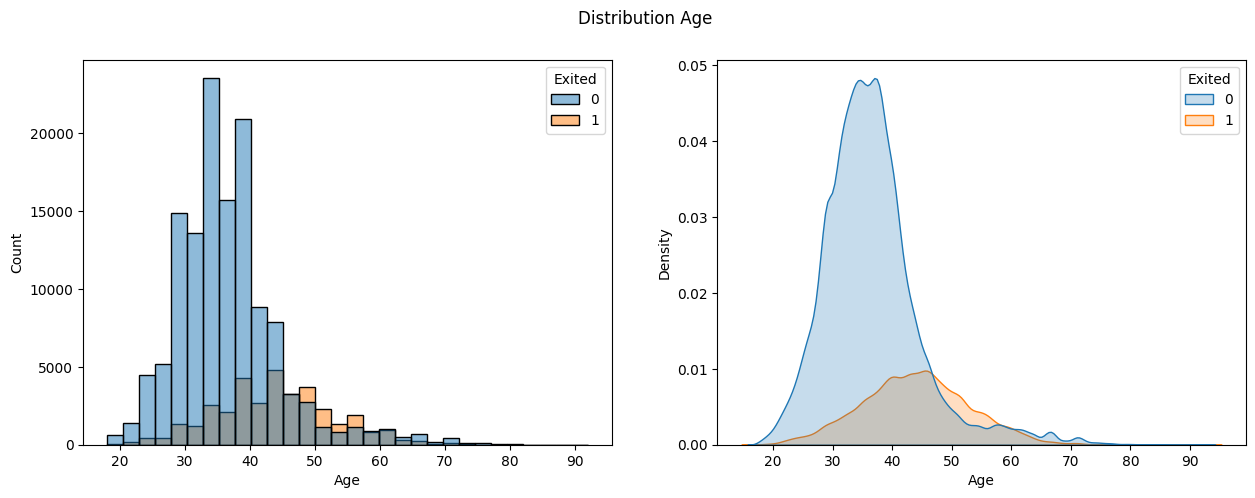

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train, x = 'Age', bins=30, hue='Exited', ax=ax[0])


sns.kdeplot(data=train, x = 'Age', hue='Exited', fill=True, ax=ax[1])
fig.suptitle("Distribution Age")
plt.show()

Here we can see how the average age of the people exited is older than those who did not. What if we divide this ages in the next categories
- Young (18-24)
- Young Adult (25-44)
- Mature Adult (45-59)
- Elderly (60+)

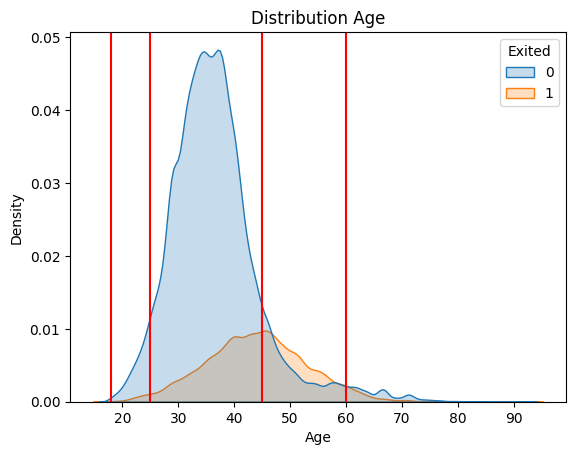

In [11]:
ages = [18,25,45,60]
sns.kdeplot(data=train, x = 'Age', hue='Exited', fill=True,)
plt.title("Distribution Age")
for a in ages:
    plt.axvline(a,c='r')
plt.show()

In [12]:
def add_age_categories(dataset):
    bins = [18, 25, 45, 60, float('inf')]
    labels = ["Y", "YA", "MA", "E"]
    dataset['AgeCategory'] = pd.cut(dataset['Age'], bins=bins, labels=labels, right=False)
    
    return dataset

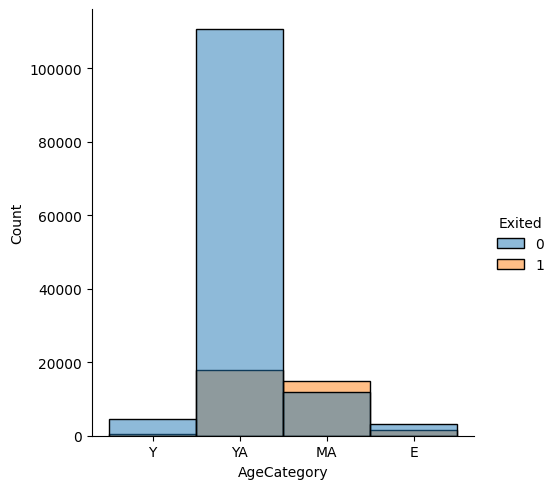

In [13]:
train = add_age_categories(train)
test = add_age_categories(test)
sns.displot(data=train, x="AgeCategory", hue='Exited')

### Tenure 
The number of years the customer has been with the bank

In [14]:
tenure = train['Tenure']
tenure.describe()
train['Tenure'] = train['Tenure'].astype(int)
test['Tenure'] = test['Tenure'].astype(int)

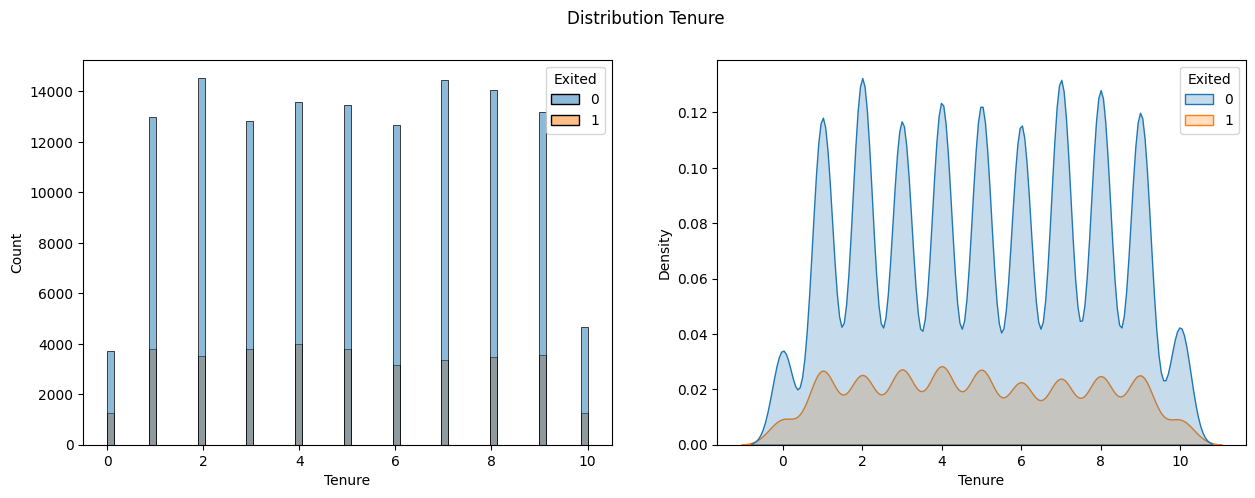

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train, x = 'Tenure', hue='Exited', ax=ax[0])

sns.kdeplot(data=train, x = 'Tenure', hue='Exited', fill=True, ax=ax[1])
fig.suptitle('Distribution Tenure')
plt.show()

Here we can see the tenure in a range between 0 and 10 years. At first glance we can not see a tendency.

### Balance 
The customer's account balance

In [16]:
balance = train['Balance']
balance.describe()

count    165034.000000
mean      55478.086689
std       62817.663278
min           0.000000
25%           0.000000
50%           0.000000
75%      119939.517500
max      250898.090000
Name: Balance, dtype: float64

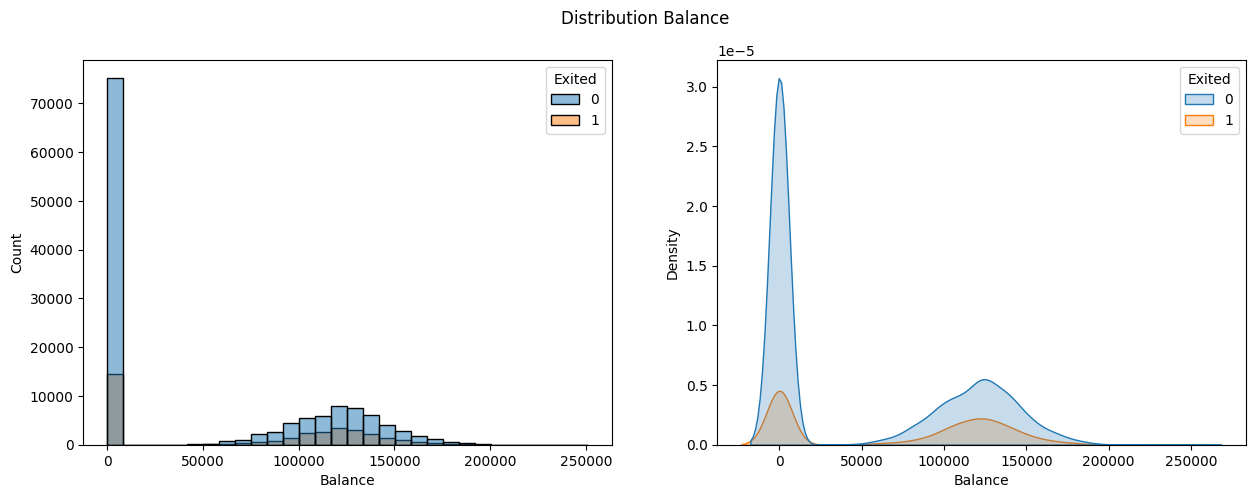

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train, x = 'Balance', bins=30, hue='Exited', ax=ax[0])


sns.kdeplot(data=train, x = 'Balance', hue='Exited', fill=True, ax=ax[1])
fig.suptitle("Distribution Balance")
plt.show()

Here we can see that there is a lot of accounts that doesn't have any balance, we can add other feature as HaveBalance.

In [18]:
train['HasBalance'] = (train['Balance'] != 0).astype(int)
test['HasBalance'] = (test['Balance'] != 0).astype(int)
balances = train.where(train['HasBalance']==1)
zero_balances = train.where(train['HasBalance']==0)

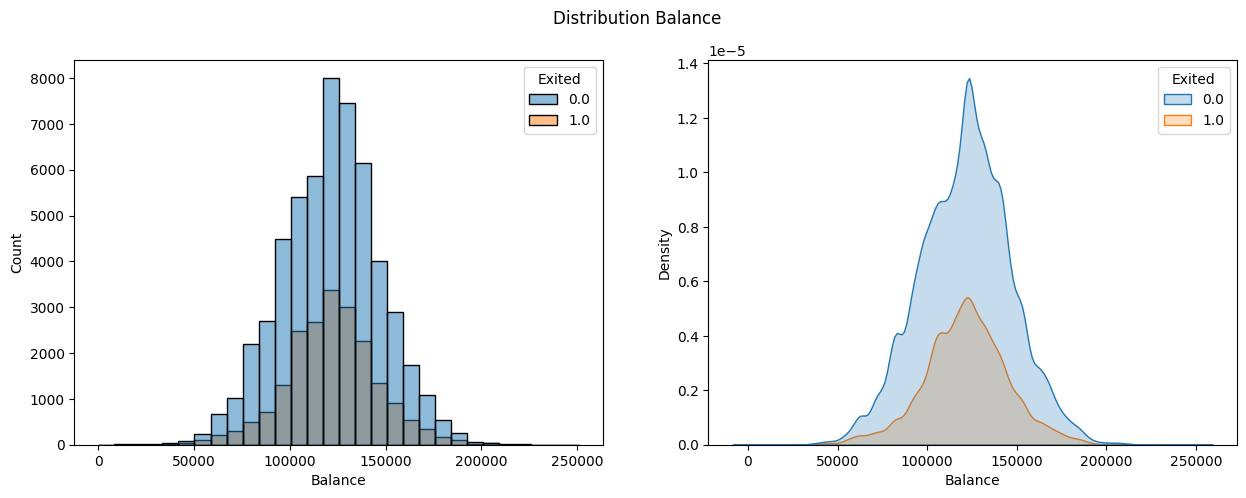

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=balances, x = 'Balance', bins=30, hue='Exited', ax=ax[0], palette='tab10')


sns.kdeplot(data=balances, x = 'Balance', hue='Exited', fill=True, ax=ax[1], palette='tab10')
fig.suptitle("Distribution Balance")
plt.show()

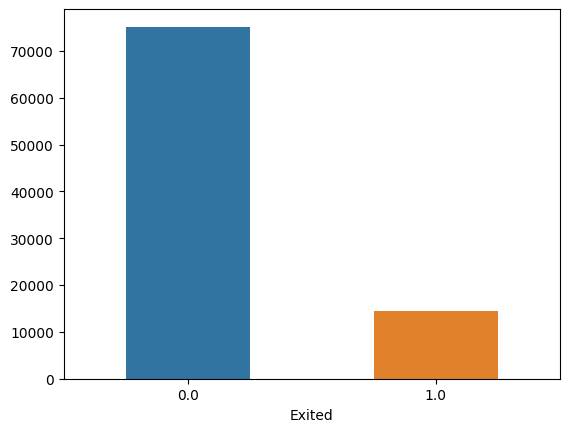

In [20]:
value_counts = zero_balances['Exited'].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values,width=0.5, )
plt.show()

### NumOfProducts 
The number of bank products the customer uses (e.g., savings account, credit card)

In [21]:
train['NumOfProducts'].describe()

train['NumOfProducts'] = train['NumOfProducts'].astype(int)
test['NumOfProducts'] = test['NumOfProducts'].astype(int)

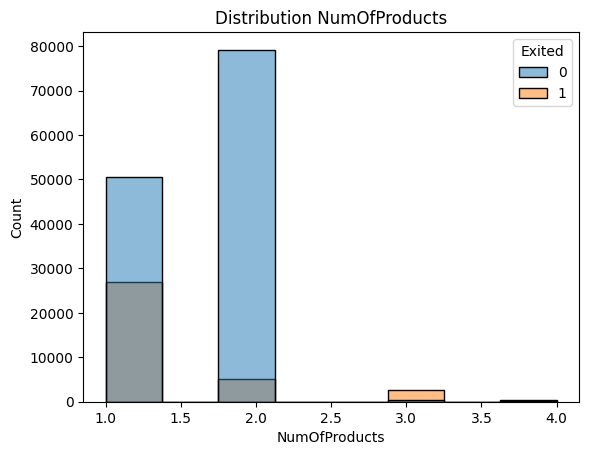

In [22]:
sns.histplot(data=train, x = 'NumOfProducts', bins=8, hue='Exited')
plt.title("Distribution NumOfProducts")
plt.show()

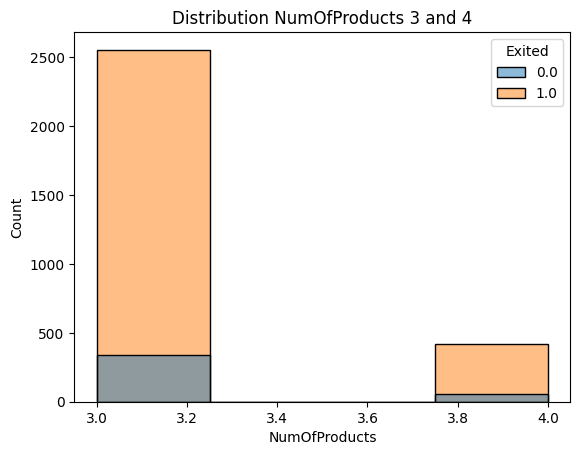

In [23]:
prod3and4 = train.where(train['NumOfProducts']>2)
sns.histplot(data=prod3and4, x = 'NumOfProducts', bins=4, hue='Exited', palette='tab10')
plt.title("Distribution NumOfProducts 3 and 4")
plt.show()

### HasCrCard 
Whether the customer has a credit card (1 = yes, 0 = no)

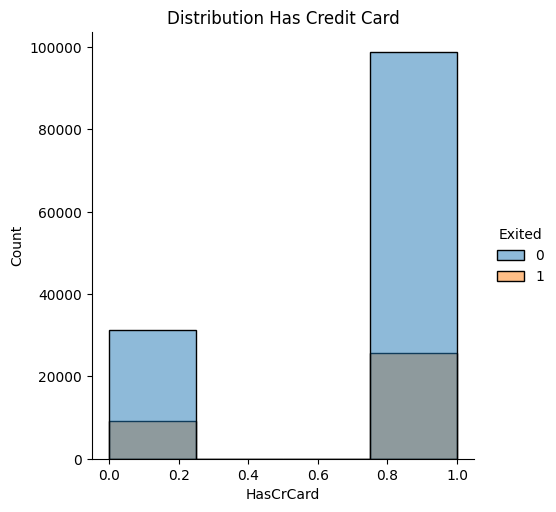

In [24]:
train['HasCrCard'] = train['HasCrCard'].astype(int)
test['HasCrCard'] = test['HasCrCard'].astype(int)
sns.displot(data=train, x = 'HasCrCard', bins=4, hue='Exited')
plt.title("Distribution Has Credit Card")
plt.show()

### IsActiveMember 
Whether the customer is an active member (1 = yes, 0 = no)

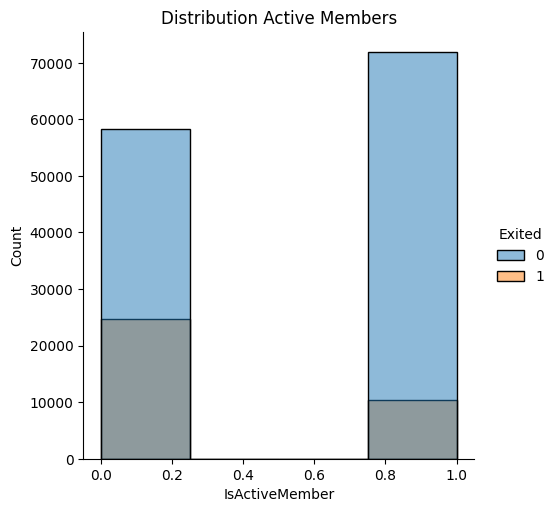

In [25]:
train['IsActiveMember'] = train['IsActiveMember'].astype(int)
test['IsActiveMember'] = test['IsActiveMember'].astype(int)
sns.displot(data=train, x = 'IsActiveMember', bins=4, hue='Exited')
plt.title("Distribution Active Members")
plt.show()

### EstimatedSalary
The estimated salary of the customer

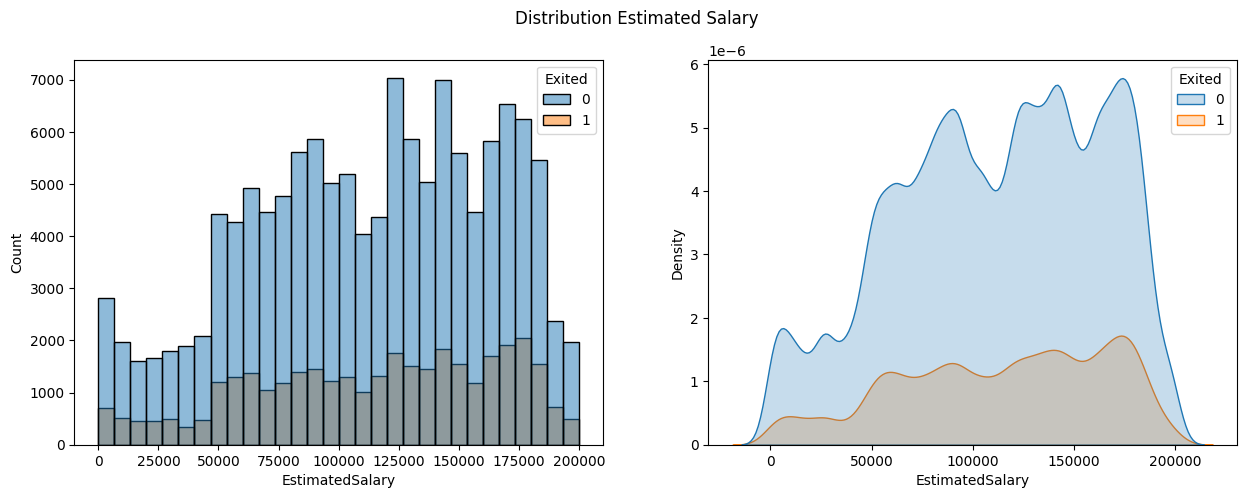

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=train, x = 'EstimatedSalary', bins=30, hue='Exited', ax=ax[0])


sns.kdeplot(data=train, x = 'EstimatedSalary', hue='Exited', fill=True, ax=ax[1])
fig.suptitle("Distribution Estimated Salary")
plt.show()

### Exited
Whether the customer has churned (1 = yes, 0 = no)

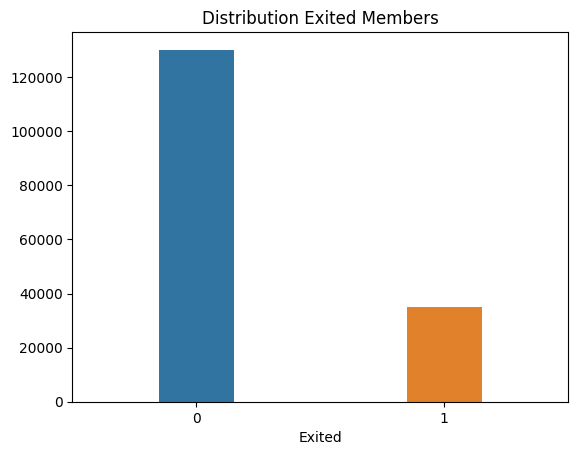

In [27]:
val = train['Exited'].value_counts()
sns.barplot(x = val.index, y=val.values, width=0.3)
plt.title("Distribution Exited Members")
plt.show()

---

## Relation between features.
Now that we have a general overview of each feature let see that we can infer other features, watching relations between features.


Maybe we can say that the Estimated Salary is high the balance will be hight too, let see.

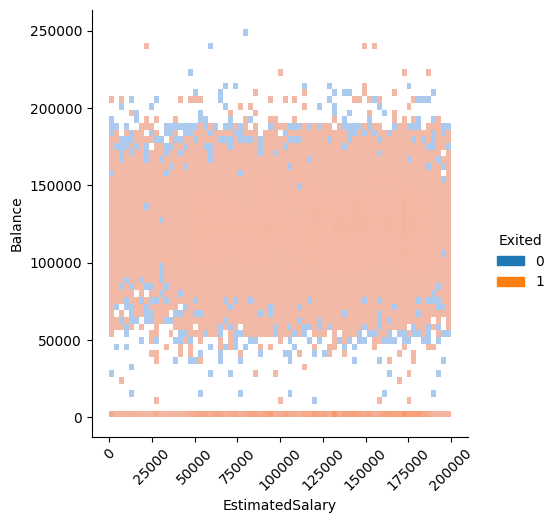

In [28]:
sns.displot(data=train, x='EstimatedSalary', y = 'Balance', hue='Exited')
plt.xticks(rotation = 45) 
plt.show()

In general, this doesn't look like this two features has a realation, but we can see that the accounts with zero balance in any estimated salary are in the "exited" side.

### Active members that use credit card

Maybe there are clients that use the account because de credit card. Here we can create a new feature "ActiveByCrCard"

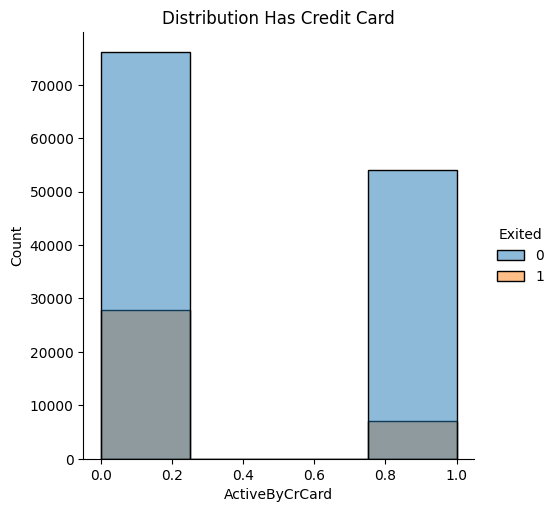

In [29]:
train['ActiveByCrCard'] = train['HasCrCard'] * train['IsActiveMember']
test['ActiveByCrCard'] = test['HasCrCard'] * test['IsActiveMember']
train['ActiveByCrCard'] = train['ActiveByCrCard'].astype(int)
test['ActiveByCrCard'] = test['ActiveByCrCard'].astype(int)
sns.displot(data=train, x = 'ActiveByCrCard', bins=4, hue='Exited')
plt.title("Distribution Has Credit Card")
plt.show()

It is clear that are more exited accounts if the client does not have a credit card.

### Active with tenure.
Maybe there are clients with tenure of some years but there are no longer active so they decide to cancel the account, so let create other feature, to see the active members with tenure.

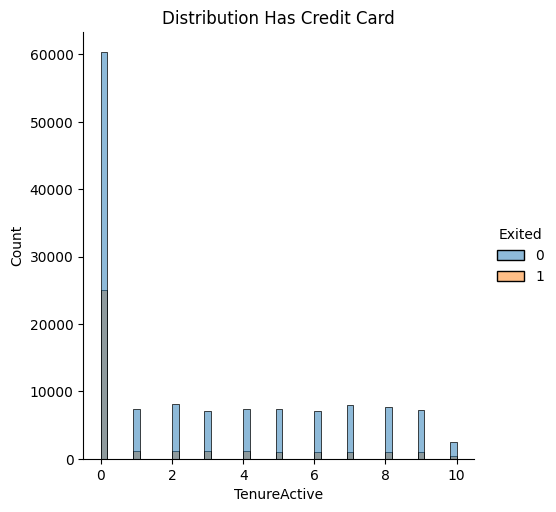

In [30]:
train['TenureActive'] = train['Tenure'] * train['IsActiveMember']
test['TenureActive'] = test['Tenure'] * test['IsActiveMember']

train['TenureActive'] = train['TenureActive'].astype(int)
test['TenureActive'] = test['TenureActive'].astype(int)
sns.displot(data=train, x = 'TenureActive', hue='Exited')
plt.title("Distribution Has Credit Card")
plt.show()

### Active with balance


In [31]:
train['ActiveBalance'] =  np.ones(len(train))
test['ActiveBalance'] =  np.ones(len(test))

train.loc[(train['IsActiveMember']==0) & (train['Balance']==0), 'ActiveBalance'] = 0
test.loc[(test['IsActiveMember']==0) & (test['Balance']==0), 'ActiveBalance'] = 0

train['ActiveBalance'] = train['ActiveBalance'].astype(int)
test['ActiveBalance'] = test['ActiveBalance'].astype(int)

With this changes now we have more features

In [32]:
X_train = train.drop(['id','CustomerId','Surname', 'Exited'], axis=1)
X_train = pd.get_dummies(X_train, columns=['Geography','AgeCategory'])
y_train = train[['Exited']]
X_test = test.drop(['id','CustomerId','Surname'], axis=1)
X_test = pd.get_dummies(X_test, columns=['Geography', 'AgeCategory'])

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    random_state=42, 
                                                    stratify=y_train)

In [34]:
models = {
    'GBC': {
        'model': GradientBoostingClassifier(n_estimators=100, validation_fraction=0.15),
        'score': "",
    },
    'LGBM': {
        'model': LGBMClassifier(),
        'score': "",
    },
    'CatBoost': {
        'model': CatBoostClassifier(silent=True),
        'score': "",
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'score': "",
    }
}

In [35]:
for name, model in models.items():
    print(f"Running {name}")
    model['model'].fit(X_train, y_train)
    y_pred = model['model'].predict(X_val)
    score = roc_auc_score(y_pred,y_val)
    print(f"The model {name}, score: {score}")
    model['score'] = score
    print("="*32)
    
    proba = model['model'].predict_proba(X_test)[:,1]

    sub = pd.DataFrame()
    sub["id"] = test["id"]
    sub["Exited"] = proba

    # Save the submission to a CSV file
    sub.to_csv(f"submission_{name}_{score}.csv", header=True, index=False)
    

Running GBC


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The model GBC, score: 0.8181137402261155
Running LGBM


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


The model LGBM, score: 0.8184308319017957
Running CatBoost
The model CatBoost, score: 0.8173745924792936
Running DecisionTree
The model DecisionTree, score: 0.6965323728170242
